In [34]:
from src import data_loader as dl
from src.model_utils import ExactGPModel
import numpy as np
import torch
import gpytorch


## Preprocessing Steps

In [2]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16
N_SYSTEMS = 10
RADIUS = 0.5

In [4]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 14 m : 59 sec



In [5]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location, df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv, 8, 16)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv, 0.05)


Dropping 27 systems producing over night


In [6]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                        df_location=df_location)
df_pv['datetime'] = datetime

In [7]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [3]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [4]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [5]:
N_DAYS = 4
N_SYSTEMS = 10
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL

COORDS = (52.1074, -0.1278)

In [6]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

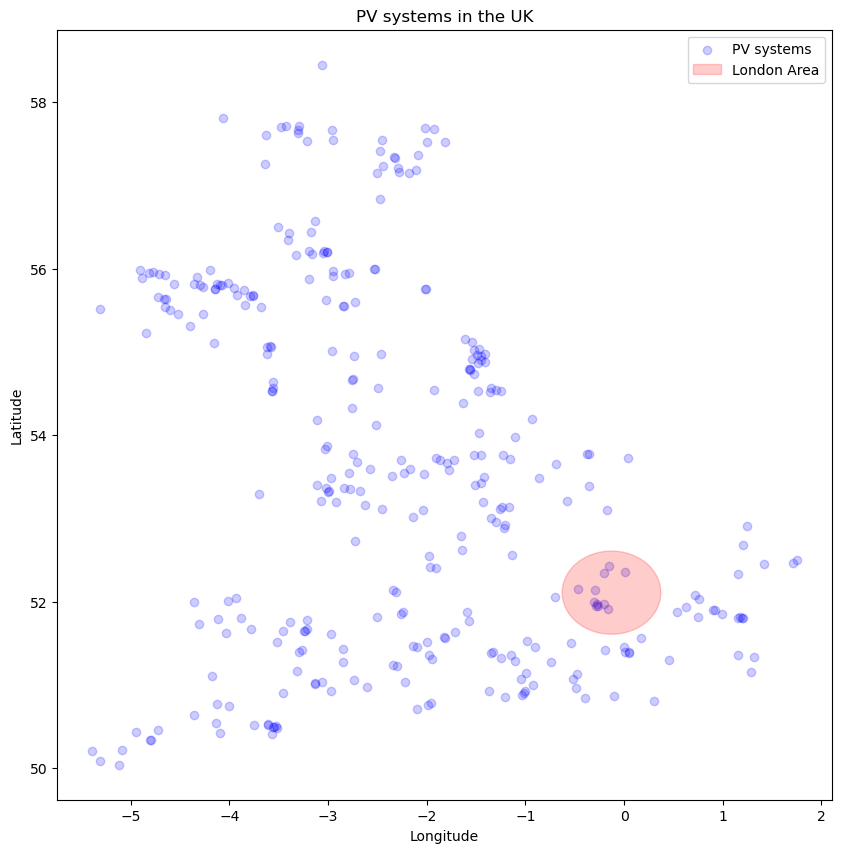

In [8]:
from src.plot_utils import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [9]:
systems, pv_systems = dl.align_pv_systems(systems, df_pv)
pv_sample = pv_systems.iloc[:int(N_DAYS * DAILY_DATA_POINTS) , :N_SYSTEMS]

In [10]:
lats, longs = dl.get_location_maps(df_location=systems, 
                                   n_systems=N_SYSTEMS)
pv_sample['datetime'] = datetime[:int(N_DAYS * DAILY_DATA_POINTS)]

In [27]:
pv_stack = dl.stack_dataframe(df_pv=pv_sample,
                                  lats_map=lats,
                                  longs_map=longs)

In [21]:
dl.save_csv(pv_stack, 'pv_data', 'pv_data_stack.csv')

In [28]:
X = pv_stack[['epoch', 'latitude', 'longitude']].values
y = pv_stack['PV'].values

In [29]:
time, r_grid, y = dl.create_spatiotemporal_grid(X, y)

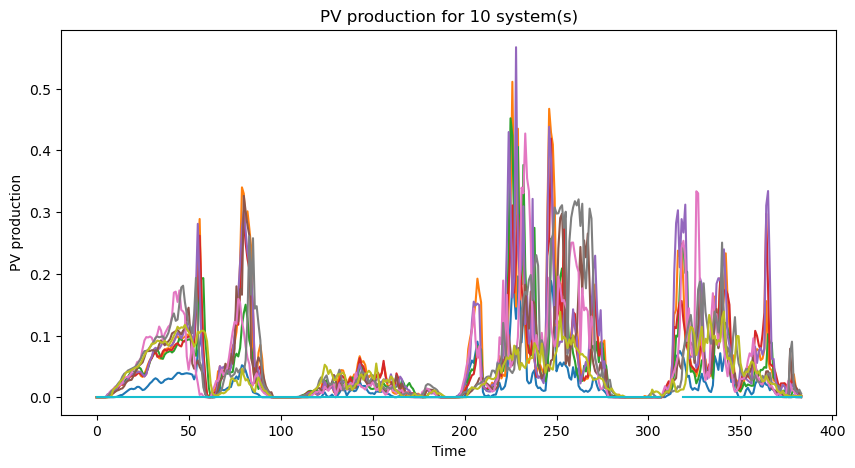

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, y[:,:,0])

ax.set_xlabel('Time')
ax.set_ylabel('PV production')
ax.set_title(f'PV production for {y.shape[1]} system(s)');

In [31]:
time_tensor, r_grid, y_tensor = dl.convert_grid_to_tensor(time=time,
                                                          r_grid=r_grid,
                                                          y=y)
time, y = dl.extract_time_series(time=time_tensor,
                                 y=y_tensor)

In [36]:
time_train, y_train, time_test, y_test = dl.train_test_split(X=time, y=y, n_hours=2)


In [51]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mean_module = gpytorch.means.ConstantMean()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=5/2))
# covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

model = ExactGPModel(train_x=time_train,
                     train_y=y_train,
                     likelihood=likelihood,
                     mean_module=mean_module,
                     covar_module=covar_module)

model._train(n_iter=900, lr=0.05, optim='Adam')

                     

Iter 1/900 - Loss: 1.071
Iter 101/900 - Loss: -1.564
Iter 201/900 - Loss: -2.678
Iter 301/900 - Loss: -2.747
Iter 401/900 - Loss: -2.764
Iter 501/900 - Loss: -2.770
Iter 601/900 - Loss: -2.773
Iter 701/900 - Loss: -2.775
Iter 801/900 - Loss: -2.776


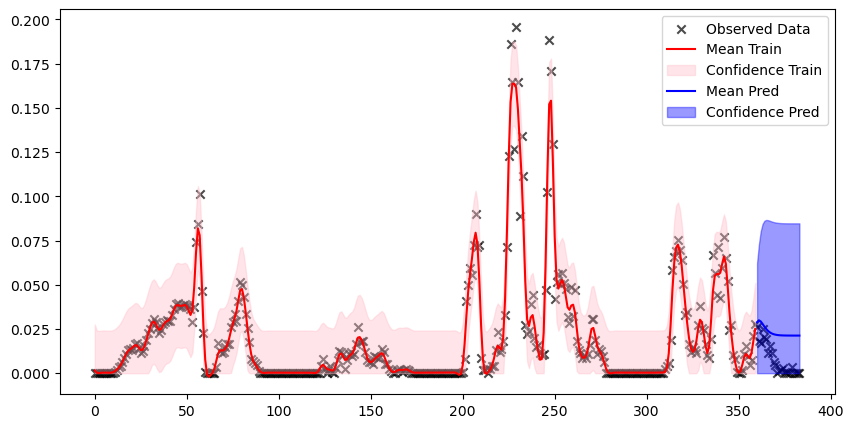

In [52]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(time_test))
    observed_pred_train = likelihood(model(time_train))

# plot predictions
plt.figure(figsize=(10, 5))

plt.scatter(time_train, y_train, marker='x', color='black', alpha=0.7, label='Observed Data')
plt.scatter(time_test, y_test, marker='x', color='black', alpha=0.7)

plt.plot(time_train, observed_pred_train.mean, 'r', label='Mean Train')

lower, upper = observed_pred_train.confidence_region()
# clip the lower and upper confidence region to avoid negative values and greater than 1
lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)
plt.fill_between(time_train, lower, upper, alpha=0.4, color='pink', label='Confidence Train')



plt.plot(time_test, observed_pred.mean, 'b', label='Mean Pred')
lower, upper = observed_pred.confidence_region()
# clip the lower and upper confidence region to avoid negative values and greater than 1
lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)

plt.fill_between(time_test, lower, upper, alpha=0.4, color='blue', label='Confidence Pred')
plt.legend()
plt.show();